#   Pumpkin Seeds - Feature reduction using PCA

- Classifying pumpkin seed varieties based on physical characteristics.

- The objective was to build a model that can accurately predict the type of a pumpkin seed using features like area, perimeter, length, and compactness.

- Dimensionality reduction techniques like PCA and KernelPCA, trained several models has been applied and evaluated their performance to find the best solution.

## Importing Libraries and Modules
We begin by importing necessary libraries for data processing, visualization, dimensionality reduction, modeling, and evaluation.


In [1]:
# import neccessary libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
!pip install openpyxl


## Loading and Exploring the Data
We load the dataset, check for null values, inspect the data, and define feature and label sets.


In [3]:
# Load data
seed = pd.read_excel('Pumpkin_Seeds_Dataset.xlsx')
seed.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Çerçevelik
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Çerçevelik
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Çerçevelik
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,Çerçevelik
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Çerçevelik


In [4]:
#check the data information to know if there is any null value
seed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ration      2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB


In [5]:
seed.isnull().sum()

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Convex_Area          0
Equiv_Diameter       0
Eccentricity         0
Solidity             0
Extent               0
Roundness            0
Aspect_Ration        0
Compactness          0
Class                0
dtype: int64

In [6]:
seed.iloc[:,-1]

0          Çerçevelik
1          Çerçevelik
2          Çerçevelik
3          Çerçevelik
4          Çerçevelik
            ...      
2495    Ürgüp Sivrisi
2496    Ürgüp Sivrisi
2497    Ürgüp Sivrisi
2498    Ürgüp Sivrisi
2499    Ürgüp Sivrisi
Name: Class, Length: 2500, dtype: object

In [7]:
#check out the column names
seed.columns

Index(['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
       'Convex_Area', 'Equiv_Diameter', 'Eccentricity', 'Solidity', 'Extent',
       'Roundness', 'Aspect_Ration', 'Compactness', 'Class'],
      dtype='object')

In [8]:
#set the x,y values
x = seed.drop('Class',axis=1)
y = seed['Class']

In [9]:
# So all 12 features in x
x.shape

(2500, 12)

## Splitting the Dataset
We split the dataset into training (60%), validation (20%), and test (20%) sets using stratified sampling.


In [10]:
# Split into train, validation, test sets (60% train, 20% val, 20% test)

x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=20, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.25, random_state=20, stratify=y_train_full)

print(f"Train shape: {x_train.shape}")
print(f"Val shape: {x_val.shape}")
print(f"Test shape: {x_test.shape}")


Train shape: (1500, 12)
Val shape: (500, 12)
Test shape: (500, 12)


#### Defining the Classification Models
We define four classifiers that will be evaluated using dimensionality reduction and hyperparameter tuning. These models include SVC, Random Forest, Logistic Regression, and K-Nearest Neighbors.


In [11]:
# Define the models
models = {
    'SVC': SVC(),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'KNN': KNeighborsClassifier()
}



#### Defining Hyperparameter Grids
We specify the hyperparameter search space for each model. These grids will be used in GridSearchCV along with PCA and KernelPCA to find the best configuration.


In [15]:
# Define hyperparameters for each model, to be used with PCA and Kernel PCA
param_grids = {
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    'RandomForest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2, 4],
        #'model__bootstrap': [True, False]
    },
    'LogisticRegression': {
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    }
}


### PCA Pipelines + GridSearchCV


 Using PCA with SVC
Best Parameters: {'model__C': 10, 'model__kernel': 'rbf'}
Validation Accuracy: 0.87
Test Classification Report:
                precision    recall  f1-score   support

   Çerçevelik       0.87      0.92      0.89       260
Ürgüp Sivrisi       0.91      0.85      0.88       240

     accuracy                           0.89       500
    macro avg       0.89      0.88      0.89       500
 weighted avg       0.89      0.89      0.89       500



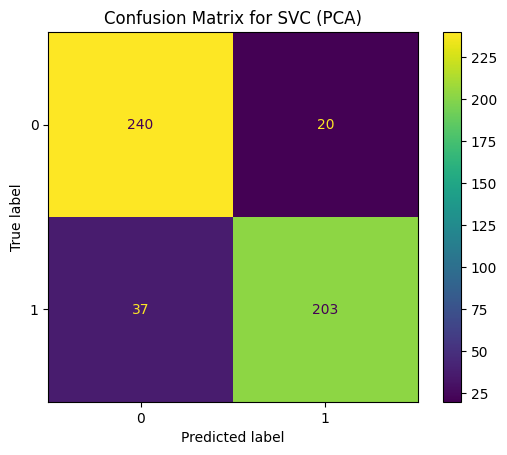


 Using PCA with RandomForest
Best Parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Validation Accuracy: 0.874
Test Classification Report:
                precision    recall  f1-score   support

   Çerçevelik       0.87      0.91      0.89       260
Ürgüp Sivrisi       0.90      0.86      0.88       240

     accuracy                           0.89       500
    macro avg       0.89      0.88      0.89       500
 weighted avg       0.89      0.89      0.89       500



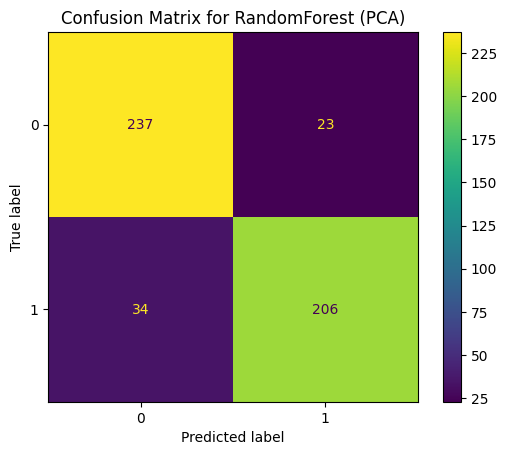


 Using PCA with LogisticRegression
Best Parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Validation Accuracy: 0.862
Test Classification Report:
                precision    recall  f1-score   support

   Çerçevelik       0.85      0.92      0.88       260
Ürgüp Sivrisi       0.90      0.83      0.86       240

     accuracy                           0.87       500
    macro avg       0.88      0.87      0.87       500
 weighted avg       0.88      0.87      0.87       500



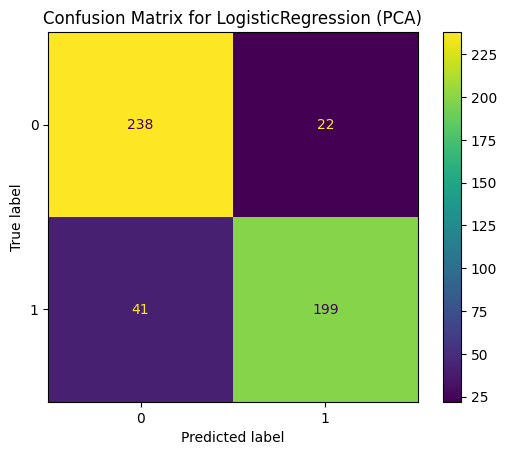


 Using PCA with KNN
Best Parameters: {'model__n_neighbors': 7, 'model__weights': 'uniform'}
Validation Accuracy: 0.864
Test Classification Report:
                precision    recall  f1-score   support

   Çerçevelik       0.87      0.93      0.90       260
Ürgüp Sivrisi       0.92      0.85      0.88       240

     accuracy                           0.89       500
    macro avg       0.89      0.89      0.89       500
 weighted avg       0.89      0.89      0.89       500



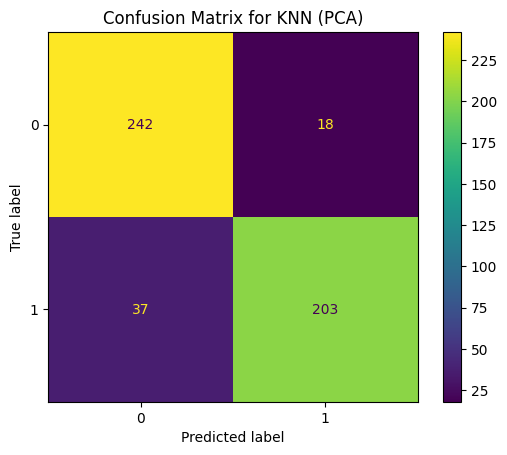

In [16]:
# To store results
results = []

# Run pipeline with PCA
for name, model in models.items():
    print(f"\n Using PCA with {name}")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=5)),
        ('model', model)
    ])
    
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)
    
    val_score = grid.score(x_val, y_val)
    test_score = grid.score(x_test, y_test)

    results.append({
        'Model': name,
        'Reduction': 'PCA',
        'Best Params': grid.best_params_,
        'Validation Accuracy': val_score,
        'Test Accuracy': test_score
    })


    print("Best Parameters:", grid.best_params_)
    print("Validation Accuracy:", val_score)

    # Evaluate on test set
    y_pred = grid.predict(x_test)
    print("Test Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"Confusion Matrix for {name} (PCA)")
    plt.show()

    

### KernelPCA Pipelines + GridSearchCV



Using KernelPCA with SVC
Best Parameters: {'kpca__gamma': 0.1, 'kpca__n_components': 3, 'model__C': 1, 'model__kernel': 'rbf'}
Validation Accuracy: 0.868
Test Classification Report:
                precision    recall  f1-score   support

   Çerçevelik       0.86      0.95      0.90       260
Ürgüp Sivrisi       0.93      0.83      0.88       240

     accuracy                           0.89       500
    macro avg       0.90      0.89      0.89       500
 weighted avg       0.89      0.89      0.89       500



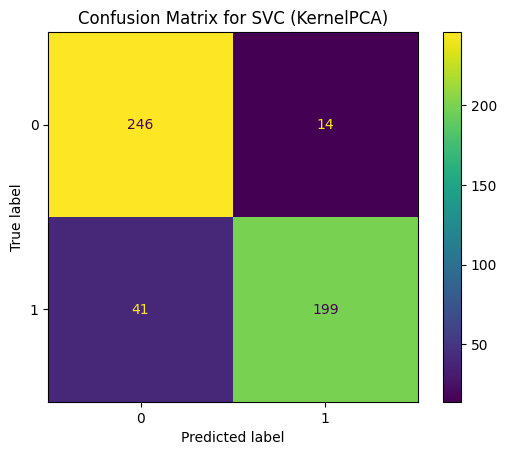


Using KernelPCA with RandomForest
Best Parameters: {'kpca__gamma': 0.1, 'kpca__n_components': 3, 'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Validation Accuracy: 0.862
Test Classification Report:
                precision    recall  f1-score   support

   Çerçevelik       0.87      0.91      0.89       260
Ürgüp Sivrisi       0.90      0.86      0.88       240

     accuracy                           0.88       500
    macro avg       0.88      0.88      0.88       500
 weighted avg       0.88      0.88      0.88       500



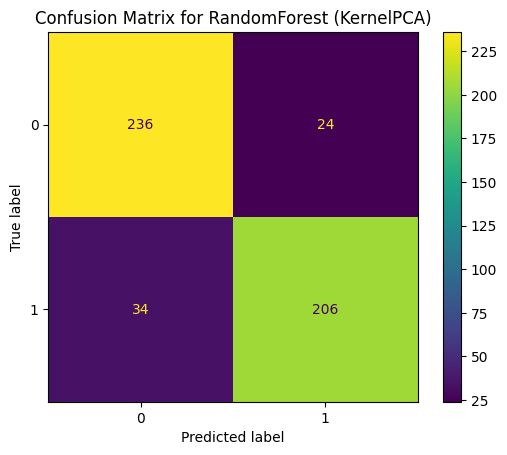


Using KernelPCA with LogisticRegression
Best Parameters: {'kpca__gamma': 0.1, 'kpca__n_components': 3, 'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Validation Accuracy: 0.866
Test Classification Report:
                precision    recall  f1-score   support

   Çerçevelik       0.85      0.92      0.88       260
Ürgüp Sivrisi       0.90      0.82      0.86       240

     accuracy                           0.87       500
    macro avg       0.87      0.87      0.87       500
 weighted avg       0.87      0.87      0.87       500



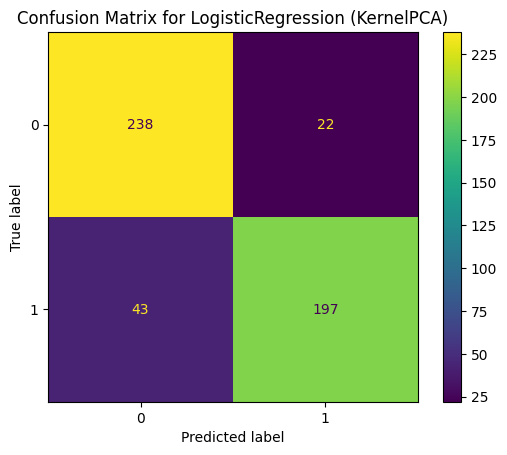


Using KernelPCA with KNN
Best Parameters: {'kpca__gamma': 0.1, 'kpca__n_components': 3, 'model__n_neighbors': 7, 'model__weights': 'uniform'}
Validation Accuracy: 0.86
Test Classification Report:
                precision    recall  f1-score   support

   Çerçevelik       0.86      0.92      0.89       260
Ürgüp Sivrisi       0.91      0.84      0.87       240

     accuracy                           0.88       500
    macro avg       0.88      0.88      0.88       500
 weighted avg       0.88      0.88      0.88       500



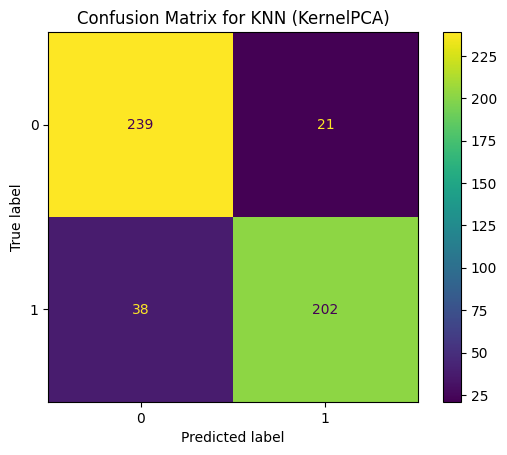

In [17]:
# Define hyperparameters for KernelPCA to use with GridSearchCV
kpca_param_grid = {
    #'kpca__n_components': [2, 3, 5],
    'kpca__n_components': [3],
    #'kpca__kernel': ['linear', 'rbf'],# Already used PCA
    #'kpca__gamma': [0.01, 0.1, 1]
    'kpca__gamma': [0.1]  # picking the one that generally works well
}

# Run pipeline with KernelPCA and classifiers
for name, model in models.items():
    print(f"\nUsing KernelPCA with {name}")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kpca', KernelPCA()),
        ('model', model)
    ])
    
    # Combine KPCA and classifier hyperparameter grids
    combined_params = {**kpca_param_grid, **param_grids[name]}

    grid = GridSearchCV(pipeline, combined_params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)

    val_score = grid.score(x_val, y_val)
    test_score = grid.score(x_test, y_test)

    results.append({
        'Model': name,
        'Reduction': 'KernelPCA',
        'Best Params': grid.best_params_,
        'Validation Accuracy': val_score,
        'Test Accuracy': test_score
    })
    
    print("Best Parameters:", grid.best_params_)
    print("Validation Accuracy:", val_score)
    
    # Evaluate on test set
    y_pred = grid.predict(x_test)
    print("Test Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"Confusion Matrix for {name} (KernelPCA)")
    plt.show()


### Results Summary and visualization

### Create a dataFrame to display results

In [18]:
# Create a DataFrame to display results

results_df = pd.DataFrame(results)
print("\nSummary of All Results:")
print(results_df.sort_values(by='Test Accuracy', ascending=False))



Summary of All Results:
                Model  Reduction  \
3                 KNN        PCA   
4                 SVC  KernelPCA   
0                 SVC        PCA   
1        RandomForest        PCA   
5        RandomForest  KernelPCA   
7                 KNN  KernelPCA   
2  LogisticRegression        PCA   
6  LogisticRegression  KernelPCA   

                                         Best Params  Validation Accuracy  \
3  {'model__n_neighbors': 7, 'model__weights': 'u...                0.864   
4  {'kpca__gamma': 0.1, 'kpca__n_components': 3, ...                0.868   
0           {'model__C': 10, 'model__kernel': 'rbf'}                0.870   
1  {'model__max_depth': 10, 'model__min_samples_l...                0.874   
5  {'kpca__gamma': 0.1, 'kpca__n_components': 3, ...                0.862   
7  {'kpca__gamma': 0.1, 'kpca__n_components': 3, ...                0.860   
2  {'model__C': 1, 'model__penalty': 'l2', 'model...                0.862   
6  {'kpca__gamma': 0.1, 'kpca__n_c

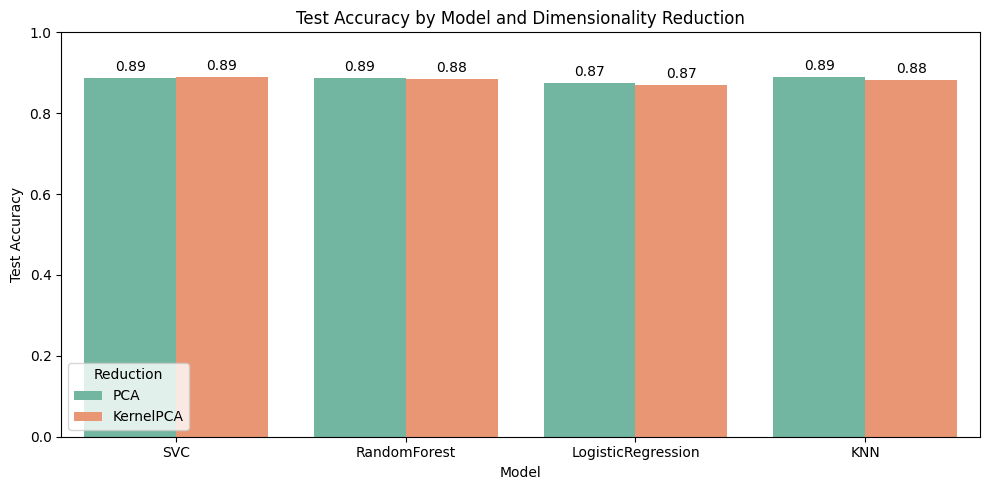

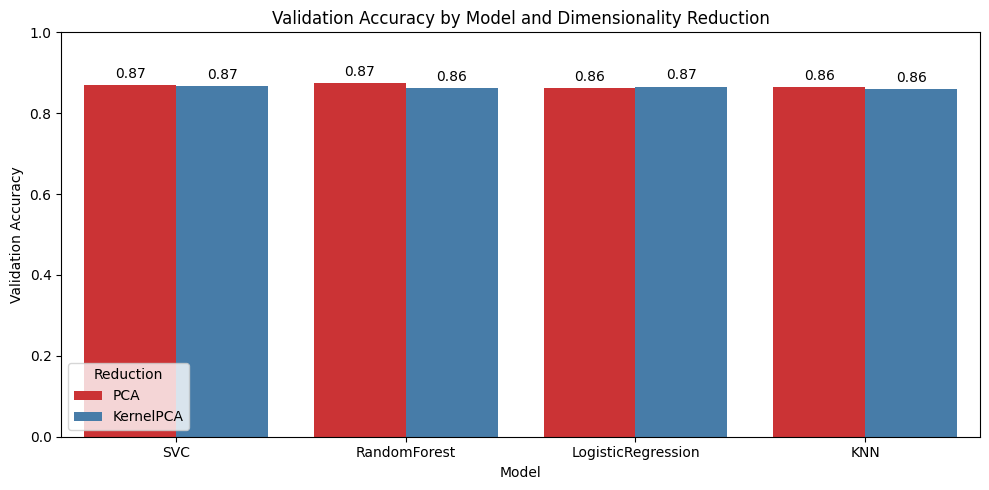

In [19]:
# Plot Test Accuracy Only
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=results_df, x='Model', y='Test Accuracy', hue='Reduction', palette='Set2')
plt.title("Test Accuracy by Model and Dimensionality Reduction")
plt.ylim(0, 1)

# Add accuracy labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

# Plot Validation Accuracy Only
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=results_df, x='Model', y='Validation Accuracy', hue='Reduction', palette='Set1')
plt.title("Validation Accuracy by Model and Dimensionality Reduction")
plt.ylim(0, 1)

# Add accuracy labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()


## Observations


General Observations
- All models perform well, with accuracies ranging between 0.86 and 0.89.
- PCA and KernelPCA produce very similar results, with PCA slightly outperforming in most cases.
- The choice of dimensionality reduction does not drastically impact model accuracy.

Test Accuracy Observations
- KNN (PCA) and SVC (KernelPCA) achieved the highest test accuracy of 0.89.
- RandomForest performs well with both PCA (0.886) and KernelPCA (0.884).
- Logistic Regression had the lowest test accuracy, with PCA (0.874) slightly better than KernelPCA (0.870).
- Overall, PCA slightly outperforms KernelPCA in test accuracy for most models.

Validation Accuracy Observations
- RandomForest (PCA) achieved the highest validation accuracy at 0.874.
- SVC performed consistently well with PCA (0.870) and KernelPCA (0.868).
- KNN showed minor variation: PCA (0.864) vs KernelPCA (0.860).
- Logistic Regression (KernelPCA) (0.866) slightly outperformed its PCA counterpart (0.862).
- Differences between PCA and KernelPCA in validation accuracy are minimal and model-dependent.